# Noise2Void

In the first exercise, we denoised images with CARE using supervised training. As 
discussed during the lecture, ground-truth data is not always available in life 
sciences. But no panic, Noise2Void is here to help!

Indeed Noise2Void is a self-supervised algorithm, meaning that it trains on the data
itself and does not require clean images. The idea is to predict the value of a masked
pixels based on the information from the surrounding pixels. Two underlying hypothesis
allow N2V to work: the structures are continuous and the noise is pixel-independent, 
that is to say the amount of noise in one pixel is independent from the amount of noise
in the surrounding pixels. Fortunately for us, it is very often the case in microscopy images!

In this notebook, we will an existing library called [Careamics](https://careamics.github.io)
that includes N2V and other algorithms:

<p align="center">
    <img src="https://raw.githubusercontent.com/CAREamics/.github/main/profile/images/banner_careamics.png" width=400>
</p>


## Reference

Alexander Krull, Tim-Oliver Buchholz, and Florian Jug. "[Noise2Void - learning denoising from single noisy images.](https://openaccess.thecvf.com/content_CVPR_2019/html/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.html)" Proceedings of the IEEE/CVF conference on Computer Vision and Pattern Recognition, 2019.

<div class="alert alert-block alert-danger\"> 
Set your kernel to `regression`.
</div>


In [1]:
import shutil
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tifffile
from careamics_portfolio import PortfolioManager

from careamics import CAREamist
from careamics.config import (
    create_n2v_configuration,
)
from careamics.transforms import N2VManipulate

<hr style="height:2px;"><div class="alert alert-block alert-success"><h1>Checkpoint 1: What is N2V really doing?</h1>
</div>

If N2V does not require pairs of noisy and clean images, then how does it train?

First it selects random pixels in each patch, then it masks them. The masking is 
not done by setting their value to 0 (which could disturb the network since it is an
unexpected value) but by replacing the value with that of one of the neighboring pixel.

Then, the network is trained to predict the value of the masked pixels. Since the masked
value is different from the original value, the network needs to use the information
contained in all the pixels surrounding the masked pixel. If the noise is pixel-independent,
then the network cannot predict the amount of noise in the original pixel and it ends
up predicting a value close to the "clean", or denoised, value.

Let's inspect how this pixel masking is done! 

## Part 1 Visualize masking algorithm

Before feeding patches to the network,
a set of transformations, or augmentations, are applied to them. Here, the masking is
simply a transformation. In CAREamics, the transformation is called N2VManipulate. It 
has different parameters: `roi_size`, `masked_pixel_percentage` and `strategy`.

In [2]:
# Define a patch size for this exercise
dummy_patch_size = 10

# Define masking parameters
roi_size = 3
masked_pixel_percentage = 5
strategy = 'uniform'

# This is simply the index of a pixel to draw a rectangle around
#highlighted_pixel_idx = 0

In [3]:
# Create a dummy patch
patch = np.arange(dummy_patch_size**2).reshape(dummy_patch_size, dummy_patch_size)

# The pixel manipulator expects a channel dimension, so we need to add it to the patch
patch = patch[..., np.newaxis]

In [4]:
# Instantiate the pixel manipulator
manipulator = N2VManipulate(
    roi_size=roi_size,
    masked_pixel_percentage=masked_pixel_percentage,
    strategy=strategy,
)

# And apply it
masked_patch, original_patch, mask = manipulator.apply(patch)


#### Define helper variables for visualization purposes

In [5]:
# Get the indices of the masked pixels
i, j = np.where(mask.squeeze())
masked_pixel_coords = np.concatenate([i[:, None], j[:, None]], axis=1)

# Get the coordinates of the one of the border pixels
#center_coords = np.flip(masked_pixel_coords[highlighted_pixel_idx]) - roi_size // 2

#### Visualize the pixel with replaced values and the mask

The cell below will visualize the patch with replaced values and the corresponding mask.

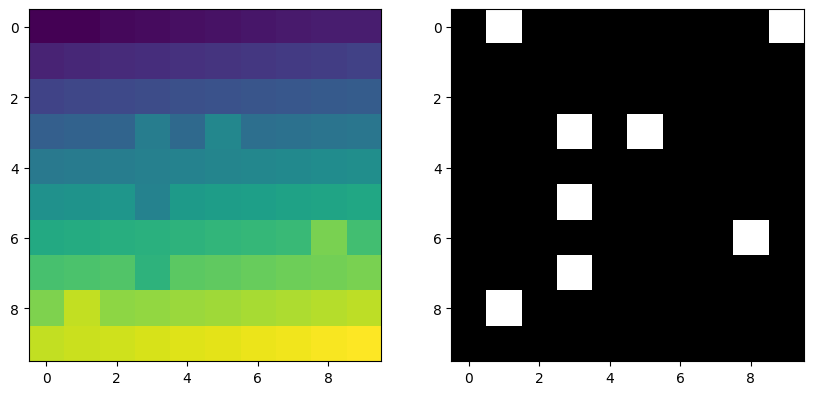

In [6]:
# Define a roi mask to visualize the masked region
#roi = plt.Rectangle(center_coords, roi_size - 1, roi_size - 1, edgecolor='r', fill=False)

# Visualize the masked patch and the mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(masked_patch)
#ax[0].add_patch(roi)
ax[1].imshow(mask, cmap="gray")

<div class="alert alert-block alert-info"><h3>Task 1: Explore the N2VManipulate parameters</h3>

Can you understand what `roi_size` does?

</div>

<div class="alert alert-block alert-info"><h3>Task 2: Uniform masking?</h3>
Visualize the probability of a pixel in the patch to be masked. Is it uniform? Why could
the "uniform strategy" refer to then?

<i>hint:</i> You need to apply the N2VManipulate transform many times and accumulate
the results.
</div>

<hr style="height:2px;"><div class="alert alert-block alert-success"><h1>Checkpoint 2: Training Noise2Void</h1>
</div>

Now that we understand how the masking works, let's train a Noise2Void network! We will
use a scanning electron microscopy image (SEM).

### Part 1. Prepare the data

For this we download the relevant dataset from the CAREamics portfolio library

In [7]:
# Explore portfolio
portfolio = PortfolioManager()
print(portfolio.denoising)

denoising datasets: ['N2V_BSD68', 'N2V_SEM', 'N2V_RGB', 'Flywing', 'Convallaria']


In [8]:
# Download files # TODO File should be reused from previous exercise
root_path = Path("./data")
files = portfolio.denoising.N2V_SEM.download(root_path)
print(f"List of downloaded files: {files}")

List of downloaded files: ['/Users/joran.deschamps/git/dl4mia/DL4MIA_image_regression/Noise2Void/data/denoising-N2V_SEM.unzip/train.tif', '/Users/joran.deschamps/git/dl4mia/DL4MIA_image_regression/Noise2Void/data/denoising-N2V_SEM.unzip/validation.tif']


#### Visualize training data

Train image shape: (2500, 1690)


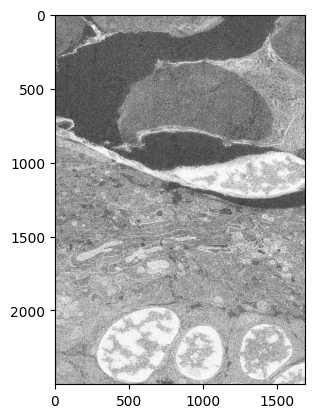

In [9]:
# Load images
train_image = tifffile.imread(files[0])
print(f"Train image shape: {train_image.shape}")
plt.imshow(train_image, cmap="gray")

#### Visualize validation data

Validation image shape: (471, 1690)


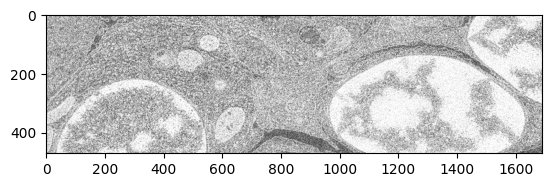

In [10]:
val_image = tifffile.imread(files[1])
print(f"Validation image shape: {val_image.shape}")
plt.imshow(val_image, cmap="gray")

In [11]:
# Set paths

data_path = Path(root_path / "n2v_sem")
train_path = data_path / "train"
val_path = data_path / "val"

train_path.mkdir(parents=True, exist_ok=True)
val_path.mkdir(parents=True, exist_ok=True)

shutil.copy(root_path / files[0], train_path / "train_image.tif")
shutil.copy(root_path / files[1], val_path / "val_image.tif")

PosixPath('data/n2v_sem/val/val_image.tif')

## Part 2: Create a configuration

CAREamics can be configured either from a yaml file, or with an explicitly created config object.
In this note book we will create the config object using helper functions. CAREamics will 
validate all the parameters and will output explicit error if some parameters or a combination of parameters isn't allowed. It will also provide default values for missing parameters.

The helper function limits the parameters to what is relevant for N2V, here is a break down of these parameters:

- `experiment_name`: name used to identify the experiment
- `data_type`: data type, in CAREamics it can only be `tiff` or `array` 
- `axes`: axes of the data, here it would be `YX`
- `patch_size`: size of the patches used for training
- `batch_size`: size of each batch
- `num_epochs`: number of epochs


There are also optional parameters, for more fine grained details:

- `use_augmentations`: whether to use augmentations (flip and rotation)
- `use_n2v2`: whether to use N2V2, a N2V variant (see optional exercise)
- `n_channels`: the number of channels 
- `roi_size`: size of the N2V manipulation region (remember that parameter?)
- `masked_pixel_percentage`: percentage of pixels to mask
- `logger`: which logger to use


Have a look at the [documentation](https://careamics.github.io) to see the full list of parameters and 
their use!



In [12]:
# Create a configuration using the helper function
training_config = create_n2v_configuration(
    experiment_name="dl4mia_n2v_load_ckpt_test",
    data_type="tiff",
    axes="YX",
    patch_size=[64, 64],
    batch_size=128,
    num_epochs=10,
    roi_size=3,
    masked_pixel_percentage=0.05,
    logger="tensorboard"
)

#### Initialize the Model

Let's instantiate the model with the configuration we just created. CAREamist is the main class of the library, it will handle creation of the data pipeline, the model, training and inference methods.

In [13]:
engine = CAREamist(source=training_config)

No working directory provided. Using current working directory: /Users/joran.deschamps/git/dl4mia/DL4MIA_image_regression/Noise2Void.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Part 3: Train

Here, we need to specify the paths to training and validation data. We can point to a folder containing 
the data or to a single file. If it fits in memory, then CAREamics will load everything and train on it. If it doesn't, then CAREamics will load the data file by file.

In [14]:
engine.train(train_source=train_path, val_source=val_path)

Extracted 1080 patches from input array.
Computed dataset mean: 39216.046875, std: 18678.18359375
Extracted 216 patches from input array.
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/joran.deschamps/git/dl4mia/DL4MIA_image_regression/Noise2Void/checkpoints exists and is not empty.

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 361 K 
-------------------------------
361 K     Trainable params
0         Non-trainable params
361 K     Total params
1.446     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 9/9 [00:49<00:00,  5.54s/it, train_loss_step=0.673, val_loss=0.628, train_loss_epoch=0.654]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 9/9 [00:49<00:00,  5.54s/it, train_loss_step=0.673, val_loss=0.628, train_loss_epoch=0.654]


<div class="alert alert-block alert-info"><h3>Task 4: Tensorboard</h3>

Remember the configuration? Didn't we set `logger` to `tensorboard`? Then we can visualize the loss curve!

Explore the local folder next to this notebook and find where the logs are stored. Then, 
start a tensorboard server and visualize the loss curve.
</div>

<div class="alert alert-block alert-info"><h3>Question: N2V loss curve</h3>

Do you remember what the loss is in Noise2Void? What is the meaning of the loss curve in that case? Can
it be easily interpreted?
</div>

<hr style="height:2px;"><div class="alert alert-block alert-success"><h1>Checkpoint 3: Prediction</h1>
</div>

We trained, but how well did it do?

## Part 4. Prediction

In order to predict on an image, we also need to specify the path. We also typically need
to cut the image into patches, predict on each patch and then stitch the patches back together.

To make the process faster, we can choose bigger tiles than the patches used during training. By default CAREamics uses tiled prediction to handle large images. The tile size can be set via the `tile_size` parameter. Tile overlap is computed automatically based on the network architecture.

In [15]:
preds = engine.predict(source=train_path, tile_size=(256, 256))

Restoring states from the checkpoint path at /Users/joran.deschamps/git/dl4mia/DL4MIA_image_regression/Noise2Void/checkpoints/last-v1.ckpt
Loaded model weights from the checkpoint at /Users/joran.deschamps/git/dl4mia/DL4MIA_image_regression/Noise2Void/checkpoints/last-v1.ckpt
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Visualize predictions

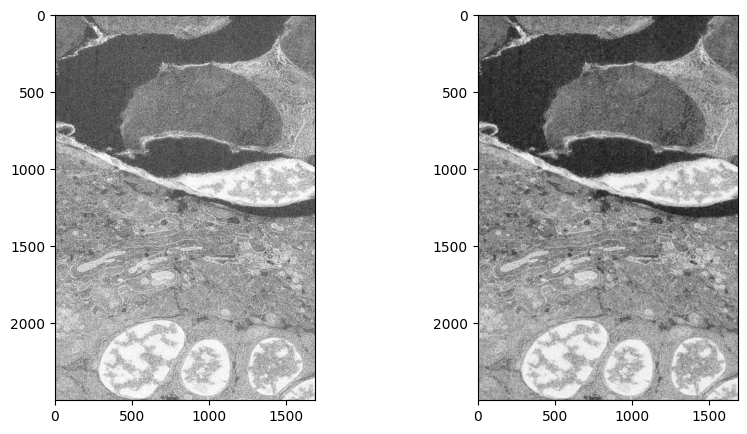

In [ ]:
# Show the full image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image, cmap="gray")
ax[1].imshow(preds.squeeze(), cmap="gray")

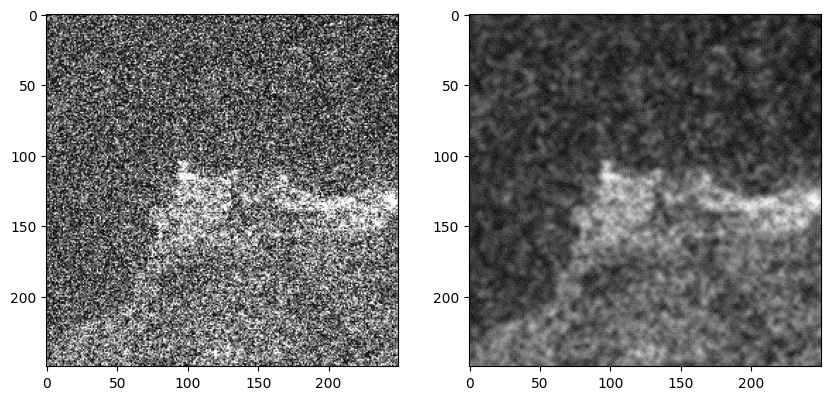

In [ ]:
# Show a close up image
y_start = 200
y_end = 450
x_start = 600
x_end = 850

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1].imshow(preds.squeeze()[y_start:y_end, x_start:x_end], cmap="gray")

<div class="alert alert-block alert-info"><h3>Task 4: Saving the prediction</h3>

Save the prediction result and the configuration to the disk.

<i>hint:</i> You can use `tifffile` to save images, and `save_configuration` method from
CAREamics.
</div>

<div class="alert alert-block alert-info"><h3>Task 5: Check the residuals</h3>

Compute what the difference between original and denoised image is. What do you see?

</div>

<div class="alert alert-block alert-info"><h3>Task 6: Improving the results</h3>

CAREamics configuration won't allow you to use parameters which are clearly wrong. However, there are many parameters that can be tuned to improve the results. Try to play around with the `roi_size` and `masked_pixel_percentage` and see if you can improve the results.

</div>

<div class="alert alert-block alert-info"><h3>Task 7: Inspect the image closely</h3>

If you got a good result, try to inspect the image closely. For instance, the default
window we used for the close-up image:

`y_start` = 200

`y_end` = 450

`x_start` = 600

`x_end` = 850


Do you see anything peculiar? What could be the reason for that?
</div>

### How to predict without training?

Here again, CAREamics provides a way to create a CAREamist from a checkpoint only,
allowing predicting without having to retrain.

In [ ]:
# Instantiate a CAREamist based on a checkpoint
other_careamist = CAREamist(source="checkpoints/last.ckpt")

# And predict
new_preds = other_careamist.predict(source=train_path, tile_size=(256, 256))

# Show the full image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image, cmap="gray")
ax[1].imshow(new_preds.squeeze(), cmap="gray")

No working directory provided. Using current working directory: /Users/joran.deschamps/git/dl4mia/DL4MIA_image_regression/Noise2Void.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: predict() missing 1 required keyword-only argument: 'checkpoint'

<hr style="height:2px;"><div class="alert alert-block alert-success"><h1>Checkpoint 5: Exporting to Bioimage Model Zoo format</h1>
</div>

## Part 5

Have you heard of the [BioImage Model Zoo](https://bioimage.io/#/)? It provides a format for FAIR AI models and allows
researchers to exchange and reproduce models. 

In [ ]:
# Export model as BMZ
# TODO


<div class="alert alert-block alert-info"><h3>Take away questions</h3>

- Which is the best network for Noise2Void, the one at the end of the training or the one with lowest validation loss?

- Is validation useful in Noise2Void?

- We predicted on the same image we trained on, is that a good idea?

- Can you reuse the model on another image?

- Can you train on images with multiple channels? RGB images? Biological channels (GFP, RFP, DAPI)?

- This is supervised, how can you be sure that the training worked and is not hallucinating?
</div>
